# Generating music

To generate music, I will use the **transformer** model, used by OpenAI in their GPT-2 model. In prior iterations, I had considered using RNNs with the seq2seq model. But after further research, I discovered that the transformer model can achieve better performance and accuracy, with the added benefit of parallelization, albeit at the cost of memory. 

In [96]:
import mido
import os
import math
import csv
import matplotlib.pyplot as plt
from itertools import chain, islice
from functools import cmp_to_key
from copy import deepcopy
from fractions import Fraction
import json
import pprint
import numpy as np

## Data Preparation

In [2]:
DATA_DIR = '../../data'

In [3]:
def get_pitch(note: int):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    return f"{notes[note % 12]}{note // 12 - 1}"

The Test Score: <br>
<img height=800 width=600 src="https://imslp.org/images/8/8b/TN-Schumann%2C_Robert_Werke_Breitkopf_Gregg_Serie_7_Band_2_RS_51_Op_13_scan.jpg"></img> <br>
Robert Schumann,Symphonic Etudes Op. 13 (with Posthumous variations)


In [4]:
# define function to play music
TEST_FILE = f'{DATA_DIR}/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--4.midi'
def play_midi(file_name=TEST_FILE):
    os.startfile(os.path.abspath(file_name))

In [5]:
is_note_on = lambda msg: msg.type == 'note_on' and msg.velocity > 0
is_note_off = lambda msg: (msg.type == 'note_on' and msg.velocity == 0) or msg.type == 'note_off'

In [6]:
# make sure to iterate over tracks for correct deltatime value (ticks), otherwise deltatime is seconds. This is also faster.
def print_messages(track, limit: int=0, *, transnote=None, transvelocity=None, transtime=None):
    transnote = transnote or (lambda note: note) 
    transvelocity = transvelocity or (lambda velocity: velocity)
    transtime = transtime or (lambda time: time)
    track = islice(track, limit) if limit > 0 else track
    for event in track:
        if is_note_on(event):
            note, velocity, time = transnote(event.note), transvelocity(event.velocity), transtime(event.time)
            print(f'note_on channel={event.channel} note={note} velocity={velocity} time={time}')
        elif is_note_off(event):
            note, velocity, time = transnote(event.note), transvelocity(event.velocity), transtime(event.time)
            print(f'note_off channel={event.channel} note={note} time={time}')
        else:
            print(event)

In [7]:
schumann = mido.MidiFile(TEST_FILE)
for event in islice(schumann.tracks[1], 50):
    print(event)

<meta message track_name name='contestant 20' time=0>
program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=127 time=0
control_change channel=0 control=67 value=0 time=0
note_on channel=0 note=73 velocity=64 time=775
note_on channel=0 note=64 velocity=41 time=41
note_on channel=0 note=68 velocity=46 time=4
note_on channel=0 note=37 velocity=39 time=8
note_on channel=0 note=61 velocity=35 time=9
note_on channel=0 note=44 velocity=30 time=8
note_on channel=0 note=73 velocity=0 time=222
note_on channel=0 note=68 velocity=0 time=45
note_on channel=0 note=64 velocity=0 time=31
note_on channel=0 note=61 velocity=0 time=113
note_on channel=0 note=68 velocity=67 time=365
note_on channel=0 note=56 velocity=45 time=28
note_on channel=0 note=64 velocity=44 time=1
note_on channel=0 note=61 velocity=44 time=14
note_on channel=0 note=68 velocity=0 time=252
note_on channel=0 note=64 velocity=0 time=50
note_on channel=0 note=61 velocity=0 time=129
note_on channel=0 note=5

In [8]:
schumann.ticks_per_beat

384

In [9]:
print_messages(schumann.tracks[1], 20, transnote=get_pitch)

<meta message track_name name='contestant 20' time=0>
program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=127 time=0
control_change channel=0 control=67 value=0 time=0
note_on channel=0 note=C#5 velocity=64 time=775
note_on channel=0 note=E4 velocity=41 time=41
note_on channel=0 note=G#4 velocity=46 time=4
note_on channel=0 note=C#2 velocity=39 time=8
note_on channel=0 note=C#4 velocity=35 time=9
note_on channel=0 note=G#2 velocity=30 time=8
note_off channel=0 note=C#5 time=222
note_off channel=0 note=G#4 time=45
note_off channel=0 note=E4 time=31
note_off channel=0 note=C#4 time=113
note_on channel=0 note=G#4 velocity=67 time=365
note_on channel=0 note=G#3 velocity=45 time=28
note_on channel=0 note=E4 velocity=44 time=1
note_on channel=0 note=C#4 velocity=44 time=14
note_off channel=0 note=G#4 time=252
note_off channel=0 note=E4 time=50


### Converting Ticks to Beats

Time attribute represents <deltatime\>. <deltatime\> is represented as number of ticks before playing the message. The number of ticks per beat is defined in the MThd chunk as <division\>. (i.e. <division\> = 96 means 96 ticks per beat). The number of microseconds per beat is defined as $500,000 \frac{\mu s}{beat}$, or can be set in the meta message 'set_tempo' in each track.

So $time = 288$, $division = 384$, $tempo = 500,000$ equates to $\frac{500,000}{384} * 288 = 375,000 \mu s$

This is the ticks between the first note_on (C#5) and the corresponding note off

This is equivalent to .375 seconds, which is the deltatime value when using `midi.play()` or `iter(midi)`



 With $500,000 \frac{\mu s}{beat}$, BPM = 120. The denominator of the time signature tells what kind of note (quarter, eighth) is a beat. The numerator tells how many beats are in bar. With a time signature of 4/4, a beat is a quarter note. 

With $time = 288$, and $division = 384$, $288 \ \text{ticks} * \frac{1}{384} \frac{beat}{tick} = .75 \ \text{beats}$

This is equal to $375,000 \mu s * \frac{1}{500000} \frac{beat}{\mu s} = .75 \ \text{beats}$.

A time signature of 4 means $time = 288$ is .75 of a quarter note. However, from the image above, the first notes are quarter notes, not fractions of quarter notes, probably because the performance was played with a different BPM in mind (Andante, maybe 90), and not the one given in the midi file. 


### Quantization

Quantize notes so that notes will have deltatime corrected to the nearest multiple of $\epsilon$. A lower $\epsilon$ means a higher frequency, but also more off-beats. A greater $\epsilon$ means lower frequency, and more synchronization.

In [10]:
BEAT_RESOLUTION = 64
BEAT = 4

In [11]:
def nearest_tick(ticks, resolution):
    temp = ticks + resolution // 2
    return int(temp - temp % resolution)

def quantize(track, resolution, ticks_per_beat, beat=4, limit: int=0):
    tick_resolution = beat * ticks_per_beat / resolution
    if limit > 0:
        track = islice(track, limit)
    return [msg.copy(time=nearest_tick(msg.time, tick_resolution)) 
            if msg.type == 'note_on' else msg.copy() 
            for msg in track]

quantized = quantize(schumann.tracks[1], resolution=BEAT_RESOLUTION, beat=BEAT, ticks_per_beat=schumann.ticks_per_beat)
print_messages(quantized, 20, transnote=get_pitch)

<meta message track_name name='contestant 20' time=0>
program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=127 time=0
control_change channel=0 control=67 value=0 time=0
note_on channel=0 note=C#5 velocity=64 time=768
note_on channel=0 note=E4 velocity=41 time=48
note_on channel=0 note=G#4 velocity=46 time=0
note_on channel=0 note=C#2 velocity=39 time=0
note_on channel=0 note=C#4 velocity=35 time=0
note_on channel=0 note=G#2 velocity=30 time=0
note_off channel=0 note=C#5 time=216
note_off channel=0 note=G#4 time=48
note_off channel=0 note=E4 time=24
note_off channel=0 note=C#4 time=120
note_on channel=0 note=G#4 velocity=67 time=360
note_on channel=0 note=G#3 velocity=45 time=24
note_on channel=0 note=E4 velocity=44 time=0
note_on channel=0 note=C#4 velocity=44 time=24
note_off channel=0 note=G#4 time=264
note_off channel=0 note=E4 time=48


In [12]:
schumann_copy = deepcopy(schumann)
schumann_copy.tracks[1] = mido.MidiTrack(quantized)

In [13]:
schumann_copy.save('schumann.midi')

## Moving Away from Midi

In [14]:
# class setup
class Note:
    def __init__(self, pitch, velocity, instrument='piano'):
        self.pitch = pitch
        self.velocity = velocity
        self.instrument = instrument

    def __str__(self):
        return f"{self.pitch}:{self.velocity}:{self.instrument}"

    def __repr__(self):
        return f"<Note pitch={self.pitch} velocity={self.velocity} instrument={self.instrument}>"

    def __eq__(self):
        return self.pitch == other.pitch and self.velocity == other.velocity and self.instrument == other.instrument

    def __hash__(self):
        return hash((self.pitch, self.velocity, self.instrument))

class Wait:
    def __init__(self, beats):
        self.beats = beats

    def duration(self):
        return self.beats
    
    def __str__(self):
        return f"wait:{self.beats}"
    
    def __repr__(self):
        return f"<Wait {self.beats}>"
    
    def __eq__(self, other):
        return self.beats == other.beats

    def __hash__(self):
        return hash(self.beats)
    

### Converting to Notes

In [15]:
def to_beats(track, tick_per_beat, limit=0):
    if limit > 0:
        track = islice(track, limit)
    tick_to_beat = lambda tick, tick_per_beat: tick / tick_per_beat 
    return [(Wait(Fraction(tick_to_beat(msg.time, tick_per_beat)).numerator), Note(get_pitch(msg.note), msg.velocity))
            for msg in track if msg.type == 'note_on']

In [16]:
schumann_seq = to_beats(schumann_copy.tracks[1], schumann_copy.ticks_per_beat)
schumann_seq[:30]

[(<Wait 2>, <Note pitch=C#5 velocity=64 instrument=piano>),
 (<Wait 1>, <Note pitch=E4 velocity=41 instrument=piano>),
 (<Wait 0>, <Note pitch=G#4 velocity=46 instrument=piano>),
 (<Wait 0>, <Note pitch=C#2 velocity=39 instrument=piano>),
 (<Wait 0>, <Note pitch=C#4 velocity=35 instrument=piano>),
 (<Wait 0>, <Note pitch=G#2 velocity=30 instrument=piano>),
 (<Wait 9>, <Note pitch=C#5 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=G#4 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=E4 velocity=0 instrument=piano>),
 (<Wait 5>, <Note pitch=C#4 velocity=0 instrument=piano>),
 (<Wait 15>, <Note pitch=G#4 velocity=67 instrument=piano>),
 (<Wait 1>, <Note pitch=G#3 velocity=45 instrument=piano>),
 (<Wait 0>, <Note pitch=E4 velocity=44 instrument=piano>),
 (<Wait 1>, <Note pitch=C#4 velocity=44 instrument=piano>),
 (<Wait 11>, <Note pitch=G#4 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=E4 velocity=0 instrument=piano>),
 (<Wait 5>, <Note pitch=C#4 velocity=0 instrumen

The last value in each tuple represents the number of beats for that note is played. Because notes were quantized with a 64th note resolution and beats set to quarter notes, each note will have a time that is some multiple of $\frac{1}{16}$. 

> When quantizing, each tick value was adjusted so that $$\text{ticks}' = x * \frac{\text{beat} * \text{ticks_per_beat}}{\text{resolution}}$$When converting to beats, $\text{ticks}'$ is divided by ticks_per_beat. $$\text{beats} = \frac{\text{ticks}'}{\text{ticks_per_beat}} = x * \frac{\text{beat} * \text{ticks_per_beat}}{\text{resolution} * \text{ticks_per_beat}} = x * \frac{\text{beat}}{\text{resolution}}$$

In [17]:
BEAT_BASE = BEAT / BEAT_RESOLUTION

Using this approach, we will have 16 waits defined in the vocabulary (wait:[1-16]). Waits longer than 1 beat will be recorded as (wait:16, wait:n). However, a constant resolution needs to be set for all songs. Test quantizing a faster song.

### Quantizing faster songs

In [18]:
TEST_FAST_FILE = f'{DATA_DIR}/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_05_Track05_wav--2.midi'
rachmaninoff = mido.MidiFile(TEST_FAST_FILE)
print_messages(rachmaninoff.tracks[1], 20)

program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=80 time=0
control_change channel=0 control=67 value=126 time=0
control_change channel=0 control=64 value=78 time=896
note_on channel=0 note=40 velocity=31 time=64
control_change channel=0 control=64 value=80 time=7
control_change channel=0 control=64 value=83 time=21
control_change channel=0 control=64 value=86 time=17
control_change channel=0 control=64 value=90 time=20
control_change channel=0 control=64 value=98 time=39
control_change channel=0 control=64 value=103 time=16
control_change channel=0 control=64 value=108 time=21
control_change channel=0 control=64 value=112 time=17
control_change channel=0 control=64 value=118 time=37
control_change channel=0 control=64 value=124 time=38
note_off channel=0 note=40 time=40
note_on channel=0 note=47 velocity=39 time=0
note_off channel=0 note=47 time=101
note_on channel=0 note=55 velocity=43 time=85
note_off channel=0 note=55 time=94


In [19]:
rachmaninoff_copy = deepcopy(rachmaninoff)
rachmaninoff_copy.tracks[1] = quantize(rachmaninoff_copy.tracks[1], 64, rachmaninoff_copy.ticks_per_beat)
print_messages(rachmaninoff_copy.tracks[1], limit=20)

program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=80 time=0
control_change channel=0 control=67 value=126 time=0
control_change channel=0 control=64 value=78 time=896
note_on channel=0 note=40 velocity=31 time=60
control_change channel=0 control=64 value=80 time=7
control_change channel=0 control=64 value=83 time=21
control_change channel=0 control=64 value=86 time=17
control_change channel=0 control=64 value=90 time=20
control_change channel=0 control=64 value=98 time=39
control_change channel=0 control=64 value=103 time=16
control_change channel=0 control=64 value=108 time=21
control_change channel=0 control=64 value=112 time=17
control_change channel=0 control=64 value=118 time=37
control_change channel=0 control=64 value=124 time=38
note_off channel=0 note=40 time=30
note_on channel=0 note=47 velocity=39 time=0
note_off channel=0 note=47 time=90
note_on channel=0 note=55 velocity=43 time=90
note_off channel=0 note=55 time=90


In [20]:
rachmaninoff_copy.save('rachmaninoff.midi')

In [21]:
to_beats(rachmaninoff_copy.tracks[1], rachmaninoff_copy.ticks_per_beat)[:30]

[(<Wait 1>, <Note pitch=E2 velocity=31 instrument=piano>),
 (<Wait 1>, <Note pitch=E2 velocity=0 instrument=piano>),
 (<Wait 0>, <Note pitch=B2 velocity=39 instrument=piano>),
 (<Wait 3>, <Note pitch=B2 velocity=0 instrument=piano>),
 (<Wait 3>, <Note pitch=G3 velocity=43 instrument=piano>),
 (<Wait 3>, <Note pitch=G3 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=F#3 velocity=38 instrument=piano>),
 (<Wait 1>, <Note pitch=F#3 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=G3 velocity=50 instrument=piano>),
 (<Wait 3>, <Note pitch=G3 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=E3 velocity=45 instrument=piano>),
 (<Wait 1>, <Note pitch=E3 velocity=0 instrument=piano>),
 (<Wait 1>, <Note pitch=G3 velocity=51 instrument=piano>),
 (<Wait 1>, <Note pitch=G3 velocity=0 instrument=piano>),
 (<Wait 0>, <Note pitch=E3 velocity=47 instrument=piano>),
 (<Wait 1>, <Note pitch=D#3 velocity=57 instrument=piano>),
 (<Wait 1>, <Note pitch=E3 velocity=0 instrument=piano>),
 (

Quantizing a faster song works fine. Quantization performance depends on the ticks per beat and the resolution. As long as ticks_per_beat is fairly small (so that tick_resolution is small), then overall resolution will be retained. In practice, we can scale down ticks_per_beat, and <set_tempo\> by the same amount. Scaling both down will keep $\frac{\mu s}{tick}$ the same, so that the absolute timings of each message are the same.

### Inserting Waits

In [22]:
def with_waits(beats_stream):
    first = True
    for wait, note in beats_stream:
        if not first and wait.duration() != 0:
            yield wait
        first = False
        yield note

In [23]:
for i in islice(with_waits(schumann_seq), 20):
    print(i)

C#5:64:piano
wait:1
E4:41:piano
G#4:46:piano
C#2:39:piano
C#4:35:piano
G#2:30:piano
wait:9
C#5:0:piano
wait:1
G#4:0:piano
wait:1
E4:0:piano
wait:5
C#4:0:piano
wait:15
G#4:67:piano
wait:1
G#3:45:piano
E4:44:piano


## Vocabulary

The full vocabulary will consist of 16 waits (or any power of 2 depending on what resolution I go with), and 128 notes, each with 32 volume levels, each with 6 instruments. A total size of 24,592.

Volumes will be binned for less noise, and to account for variability in performances.

For now I'll just stick with piano, so 88 notes (A0-C8), 32 volumes, 1 instrument, 16 waits. A total size of 2832. 

## Metadata + Features

### Additional Features

Aside from the vocabulary, I will train the model with the following features:

- [x] composer
- ~~key signature~~ (data not available)
- [x] tempo
- [x] time period/style


In [32]:
with open(f'{DATA_DIR}/maestro-v3.0.0/maestro-v3.0.0.csv', encoding='utf-8') as csvfile:
    reader = list(csv.DictReader(csvfile))

In [24]:
with open(f'{DATA_DIR}/metadata/composers.json') as composer_file:
    composers = json.load(composer_file)

For composer searching, I will need to clean up the csv file to make sure that composer names match up with the names given in the composers file.

### Epoch

In [25]:
def epoch(complete_name: str):
    result = [composer for composer in composers if composer['complete_name'].lower() == complete_name.lower()]
    if len(result) > 0:
        return result[0]['epoch']
    return None

In [26]:
epoch('Leoš Janáček')

'Late Romantic'

### Tempo

In [81]:
def time_per_msg(num_msgs, duration):
    "higher value means slower piece"
    return (duration / num_msgs) * 1000

def get_duration(filename, csv_meta):
    return float([row for row in csv_meta if row['midi_filename'] == filename][0]['duration'])

def get_midi_filename(abs_filename):
    year = os.path.basename(os.path.dirname(abs_filename))
    return os.path.join(year, os.path.basename(abs_filename)).replace(os.path.sep, '/')

In [82]:
rachmaninoff_abs_filename = os.path.abspath(TEST_FAST_FILE)
schumann_abs_filename = os.path.abspath(TEST_FILE)

rachmaninoff_duration = get_duration(get_midi_filename(rachmaninoff_abs_filename), reader)
schumann_duration = get_duration(get_midi_filename(schumann_abs_filename), reader)

rachmaninoff_msgs_per_time = time_per_msg(len(rachmaninoff.tracks[1]), rachmaninoff_duration)
schumann_msgs_per_time = time_per_msg(len(schumann.tracks[1]), schumann_duration)

display(len(rachmaninoff.tracks[1]), len(schumann.tracks[1]))
print('\n')
display(rachmaninoff_duration, schumann_duration)
print('\n')
display(rachmaninoff_msgs_per_time, schumann_msgs_per_time)

8000

108940

158.014182992

2096.39614078

19.751772874

19.243584916284195

In [84]:
# An example with Chopin nocturne
TEST_CHOPIN = '2015/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--3.midi'
chopin_duration = get_duration(TEST_CHOPIN, reader)
chopin_time_per_msg = time_per_msg(len(mido.MidiFile(f'{DATA_DIR}/maestro-v3.0.0/{TEST_CHOPIN}').tracks[1]), chopin_duration)
f'Chopin time per msg: {chopin_time_per_msg}'

'Chopin time per msg: 35.08185609381383'

In [99]:
# Distribution
years = [2004, 2006, 2008, 2009, 2011, 2013, 2014, 2015, 2017, 2018]

def get_midi_files():
    for year in years:
        yield from (get_midi_filename(os.path.abspath(entry.path)) for entry in os.scandir(f'{DATA_DIR}/maestro-v3.0.0/{year}'))

abs_midi_files = (f'{DATA_DIR}/maestro-v3.0.0/{filepath}' for filepath in get_midi_files())
midi_objs = (mido.MidiFile(abs_path) for abs_path in abs_midi_files)
zipped_obj_filenames = zip(midi_objs, get_midi_files())
all_time_per_msg = [time_per_msg(len(obj.tracks[1]), get_duration(path, reader)) for obj, path in zipped_obj_filenames]

(array([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.]]),
 array([8.99025867e-05, 1.00408274e+01, 2.00815650e+01, 3.01223025e+01,
        4.01630401e+01, 5.02037776e+01, 6.02445151e+01, 7.02852527e+01,
        8.03259902e+01, 9.03667277e+01, 1.00407465e+02]),
 <a list of 2 BarContainer objects>)

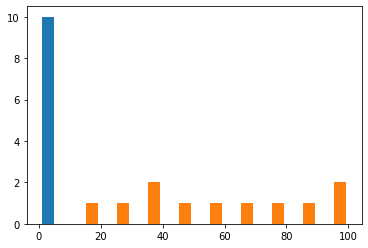

In [98]:
hist = np.histogram(all_time_per_msg, density=True, bins=10)
plt.hist(hist)

Because most of the tempos are piled around 0, it may just be noise. Remove from model.

### Composers

In [33]:
# Unique Composers
unique_composers = set()
for row in reader:
    unique_composers.add(row['canonical_composer'])
unique_composers

{'Alban Berg',
 'Alexander Scriabin',
 'Antonio Soler',
 'Carl Maria von Weber',
 'Charles Gounod / Franz Liszt',
 'Claude Debussy',
 'César Franck',
 'Domenico Scarlatti',
 'Edvard Grieg',
 'Felix Mendelssohn',
 'Felix Mendelssohn / Sergei Rachmaninoff',
 'Franz Liszt',
 'Franz Liszt / Camille Saint-Saëns',
 'Franz Liszt / Vladimir Horowitz',
 'Franz Schubert',
 'Franz Schubert / Franz Liszt',
 'Franz Schubert / Leopold Godowsky',
 'Fritz Kreisler / Sergei Rachmaninoff',
 'Frédéric Chopin',
 'George Enescu',
 'George Frideric Handel',
 'Georges Bizet / Ferruccio Busoni',
 'Georges Bizet / Moritz Moszkowski',
 'Georges Bizet / Vladimir Horowitz',
 'Giuseppe Verdi / Franz Liszt',
 'Henry Purcell',
 'Isaac Albéniz',
 'Isaac Albéniz / Leopold Godowsky',
 'Jean-Philippe Rameau',
 'Johann Christian Fischer / Wolfgang Amadeus Mozart',
 'Johann Pachelbel',
 'Johann Sebastian Bach',
 'Johann Sebastian Bach / Egon Petri',
 'Johann Sebastian Bach / Ferruccio Busoni',
 'Johann Sebastian Bach / Fr

There is a possibility of multiple composers. When this happens, choose the more common composer.

### CSV and Composer Cross Reference

In [34]:
composers_both_present = dict()
for u_composer in unique_composers:
    split_composers = u_composer.split(' / ')
    for comp_name in split_composers:
        comp_entry = [entry for entry in composers if entry['complete_name'] == comp_name]
        comp_entry = comp_entry[0] if len(comp_entry) > 0 else None
        composers_both_present[comp_name] = comp_entry
pprint.pprint(composers_both_present)

{'Alban Berg': {'birth': '1885-01-01',
                'complete_name': 'Alban Berg',
                'death': '1935-01-01',
                'epoch': '20th Century',
                'id': '210',
                'name': 'Berg',
                'portrait': 'https://assets.openopus.org/portraits/48656640-1568084861.jpg'},
 'Alexander Scriabin': {'birth': '1872-01-01',
                        'complete_name': 'Alexander Scriabin',
                        'death': '1915-01-01',
                        'epoch': 'Late Romantic',
                        'id': '18',
                        'name': 'Scriabin',
                        'portrait': 'https://assets.openopus.org/portraits/33736318-1568084946.jpg'},
 'Alfred Grünfeld': None,
 'Antonio Soler': None,
 'Camille Saint-Saëns': {'birth': '1835-01-01',
                         'complete_name': 'Camille Saint-Saëns',
                         'death': '1921-01-01',
                         'epoch': 'Romantic',
                         'id': '4

In [35]:
composers_not_present = [entry for entry in composers_both_present if composers_both_present[entry] is None]
print(f"Number not found in composer file: {len(composers_not_present)}")
composers_not_present

Number not found in composer file: 18


['Leopold Godowsky',
 'Johann Christian Fischer',
 'Orlando Gibbons',
 'Myra Hess',
 'Johann Strauss',
 'Alfred Grünfeld',
 'Muzio Clementi',
 'Mikhail Glinka',
 'Joseph Haydn',
 'Vladimir Horowitz',
 'Vyacheslav Gryaznov',
 'Nikolai Medtner',
 'Mikhail Pletnev',
 'Moritz Moszkowski',
 'Fritz Kreisler',
 'Egon Petri',
 'György Cziffra',
 'Antonio Soler']

Some of these are surprising. For example Joseph Haydn is a very famous classical composer. Upon looking at the composers.json file, we can see that the names differ. Joseph Haydn is Joseph Franz Haydn in the composers.json file.

In [36]:
approximate_composer_matches = dict()
for not_present in composers_not_present:
    last_name = not_present.split()[-1]
    comp_entry = [entry for entry in composers if last_name in entry['complete_name']]
    comp_entry = comp_entry[0] if len(comp_entry) > 0 else None
    approximate_composer_matches[not_present] = comp_entry
pprint.pprint(approximate_composer_matches)

{'Alfred Grünfeld': None,
 'Antonio Soler': None,
 'Egon Petri': None,
 'Fritz Kreisler': None,
 'György Cziffra': None,
 'Johann Christian Fischer': None,
 'Johann Strauss': {'birth': '1825-01-01',
                    'complete_name': 'Johann Strauss Jr',
                    'death': '1899-01-01',
                    'epoch': 'Romantic',
                    'id': '165',
                    'name': 'Strauss Jr',
                    'portrait': 'https://assets.openopus.org/portraits/93853123-1568084951.jpg'},
 'Joseph Haydn': {'birth': '1732-01-01',
                  'complete_name': 'Franz Joseph Haydn',
                  'death': '1809-01-01',
                  'epoch': 'Classical',
                  'id': '208',
                  'name': 'Haydn',
                  'portrait': 'https://assets.openopus.org/portraits/21056059-1568084909.jpg'},
 'Leopold Godowsky': None,
 'Mikhail Glinka': {'birth': '1804-01-01',
                    'complete_name': 'Mikhail Ivanovich Glinka',
          

At the end of it all, there's still some missing composers, which we'll just label as 'Other.'

## Test playback

In [37]:
# Test playback original
play_midi()

In [38]:
# Test playback quantized
play_midi('schumann.midi')

In [39]:
# Test playback original (fast)
play_midi(TEST_FAST_FILE)

In [40]:
# Test playback quantized (fast)
play_midi('rachmaninoff.midi')